# American sign language neural networks

In [1]:
# import basic libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [387]:
# Auxiliary functions
# function to load images
def input_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for d in os.listdir(folder):
        if not d.startswith('.'):
            if d in ['A']:
                label = 0
            elif d in ['B']:
                label = 1
            elif d in ['C']:
                label = 2
            elif d in ['D']:
                label = 3
            elif d in ['E']:
                label = 4
            elif d in ['F']:
                label = 5
            elif d in ['G']:
                label = 6
            elif d in ['H']:
                label = 7
            elif d in ['I']:
                label = 8
            elif d in ['J']:
                label = 9
            elif d in ['K']:
                label = 10
            elif d in ['L']:
                label = 11
            elif d in ['M']:
                label = 12
            elif d in ['N']:
                label = 13
            elif d in ['O']:
                label = 14
            elif d in ['P']:
                label = 15
            elif d in ['Q']:
                label = 16
            elif d in ['R']:
                label = 17
            elif d in ['S']:
                label = 18
            elif d in ['T']:
                label = 19
            elif d in ['U']:
                label = 20
            elif d in ['V']:
                label = 21
            elif d in ['W']:
                label = 22
            elif d in ['X']:
                label = 23
            elif d in ['Y']:
                label = 24
            elif d in ['Z']:
                label = 25
            elif d in ['del']:
                label = 26
            elif d in ['nothing']:
                label = 27
            elif d in ['space']:
                label = 28           
            else:
                label = 29
            for file in tqdm(os.listdir(folder + d)):
                img_file = cv2.imread(folder + d + '/' + file)
                if img_file is None:
                    continue
#                 print(img_file)
#                 print("================================")
                img_file = skimage.transform.resize(img_file, (img_size, img_size))
                img = np.asarray(img_file)
                X.append(img)
                y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Parameters

In [488]:
channels = 1
img_size = 28     
in_size = img_size*img_size*channels
out_size = 25           # number of classes
n_feat = img_size*img_size
epochs = 10       
batch_size = 100
learning_rate = 0.001
momentum = 0.9
n_hidden = 128         # number of hidden units


In [480]:
# Create custom dataloader object for dataset 1
class asl_dataset(torch.utils.data.Dataset):

  def __init__(self, src_file, num_rows=None):
    y_tmp = src_file['label']
    y_tmp = y_tmp.values
    x_tmp = src_file.drop('label', axis=1)
    x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:784]
    label = self.y_data[idx]
    #sample = \
    #  { 'pixels' : preds, 'class' : pol }
    return image, label

# Create custom dataloader object for dataset 2
class asl64_dataset(torch.utils.data.Dataset):

  def __init__(self, data, label, num_rows=None):
    y_tmp = label
    #y_tmp = y_tmp.values
    x_tmp = data
    #x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:12288]
    label = self.y_data[idx]
    return image, label

## Loaders

In [493]:
# load dataset 2 (asl alphabet kaggle)
from tqdm import tqdm
import cv2
import skimage

train_dir = "../../../data/asl_alphabet/asl_alphabet_train/asl_alphabet_train/"
#test_dir = "../../../data/asl_alphabet/asl_alphabet_test/asl_alphabet_test/"

# To use only if reload needed
#xtrain, ytrain = input_data(train_dir)
#xtest, ytest = get_data(test_dir)

# Preloaded numpy arrays
#xdata = np.load('xtrain.npy')
#ydata = np.load('ytrain.npy')
#xtest = np.load('xtest.npy')
#ytest = np.load('ytest.npy')
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

transform = tt.Compose(
    [
        tt.Resize(32),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

dataset = ImageFolder(train_dir, transform)

from sklearn.model_selection import train_test_split
xtrain_s, xtest_s, ytrain_s, ytest_s = train_test_split(dataset, ydata, test_size=0.2)

train_data64_ds = asl64_dataset(xtrain_s, ytrain_s)
test_data64_ds = asl64_dataset(xtest_s, ytest_s)
train_data64_ldr = torch.utils.data.DataLoader(train_data64_ds, batch_size=batch_size, shuffle=True)
test_data64_ldr = torch.utils.data.DataLoader(test_data64_ds, batch_size=len(test_data64_ds), shuffle=True)


ValueError: only one element tensors can be converted to Python scalars

In [482]:
# read data
# dataset 1
train_data_raw = pd.read_csv('../../data/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('../../data/sign_mnist_test.csv', sep=",")
all_data_raw = pd.concat([train_data_raw,test_data_raw], axis=0)

# load dataset 1 (MNIST csv)
# load torch data loaders
train_data_ds = asl_dataset(train_data_raw)
test_data_ds = asl_dataset(test_data_raw)
train_data_ldr = torch.utils.data.DataLoader(train_data_ds, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data_ds, batch_size=len(test_data_ds), shuffle=True)

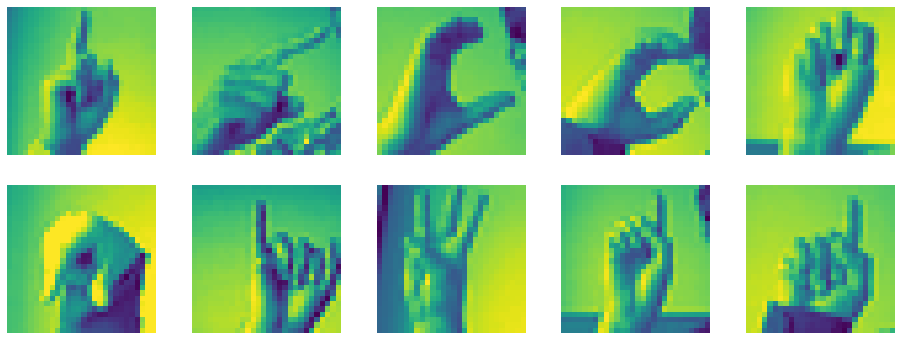

In [483]:
# # Show sample dataset 1, method 2
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_data_ldr.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().reshape(img_size,img_size,channels))
    plt.axis('off');

In [484]:
# Create network arquitectures
# simplest NN architecture
class simple(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(simple, self).__init__()
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.out_size = out_size
        #super().__init__()
        self.network = nn.Sequential(
            nn.Linear(self.in_size, self.n_hidden), 
            nn.ReLU(), 
            nn.Linear(self.n_hidden, self.out_size)
        )

    def forward(self, x):
        x = x.view(-1, self.in_size)
        return self.network(x)
        #return self.network(xb.view(xb.size(0), -1))
        

# Gunnika architecture
class convolutional(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(convolutional, self).__init__()
        self.conv1 = nn.Conv2d(channels,10,kernel_size = 3)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 3)
        self.conv3 = nn.Conv2d(20,30,kernel_size = 3)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(30*3*3, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 30*2*2)
        self.fc3 = nn.Linear(30*2*2, out_size)
        
        self.softmax = nn.LogSoftmax(dim=-1)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        #print(x.shape)

        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.softmax(x)
        
        return x

    def forward(self,x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
        

In [485]:

accuracy_list = []

def train(epoch, model, data_loader, optim, lr, momentum):
    model.train()
    optimizer = optim(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        #data = data.view(-1, img_size*img_size*channels) # simple
        data = data.view(-1, channels, img_size, img_size) # convolutional

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target) #cross entropy loss
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
    scheduler.step()
            
def test(model, data_loader): # same as train but using eval()
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        
        #data = data.view(-1, img_size*img_size*channels) # simple network
        data = data.view(-1, channels,img_size,img_size) # convolutional
        
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset),accuracy))

## Model

In [489]:
import torch.optim.lr_scheduler
# instantiate and run nn
model_fnn = simple(in_size, n_hidden, out_size)
#model_fnn = convolutional(in_size, n_hidden, out_size)


#to_device(model_fnn, device)
model_fnn.to(device)
optimizer = torch.optim.SGD

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1) # convolutional

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 25]           3,225
Total params: 103,705
Trainable params: 103,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [490]:
for epoch in range(0, epochs):
    train(epoch, model_fnn, train_data_ldr, optimizer, learning_rate, momentum)
    test(model_fnn, test_data_ldr)

Train Epoch: 0 [0/27455 (0%)]	Loss: 64.082527
Train Epoch: 0 [10000/27455 (36%)]	Loss: 3.217556
Train Epoch: 0 [20000/27455 (73%)]	Loss: 3.198764

Test set: Average loss: 3.2186, Accuracy: 246/7172 (3%)

Train Epoch: 1 [0/27455 (0%)]	Loss: 3.224046
Train Epoch: 1 [10000/27455 (36%)]	Loss: 3.220508
Train Epoch: 1 [20000/27455 (73%)]	Loss: 3.208425

Test set: Average loss: 3.2169, Accuracy: 246/7172 (3%)

Train Epoch: 2 [0/27455 (0%)]	Loss: 3.214537
Train Epoch: 2 [10000/27455 (36%)]	Loss: 3.213662
Train Epoch: 2 [20000/27455 (73%)]	Loss: 3.208048

Test set: Average loss: 3.2156, Accuracy: 246/7172 (3%)

Train Epoch: 3 [0/27455 (0%)]	Loss: 3.205510
Train Epoch: 3 [10000/27455 (36%)]	Loss: 3.208594
Train Epoch: 3 [20000/27455 (73%)]	Loss: 3.208886

Test set: Average loss: 3.2147, Accuracy: 246/7172 (3%)

Train Epoch: 4 [0/27455 (0%)]	Loss: 3.204220
Train Epoch: 4 [10000/27455 (36%)]	Loss: 3.205531
Train Epoch: 4 [20000/27455 (73%)]	Loss: 3.212708

Test set: Average loss: 3.2140, Accuracy: